# Training Neural Networks

### (1) Neural Network on BOW data

In [9]:
%%capture
%pip install tensorflow==1.15 keras==1.15

In [2]:
import numpy as np
import scipy.io
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import keras
from keras import layers
import tensorflow as tf

In [3]:
# Load the dataset for training
train_bow = scipy.io.loadmat('datasets/top_nk_train.mat')
X_train_bow = train_bow['X']
X_train_bow = X_train_bow.toarray()
X_train_bow.shape 


(8000, 10000)

In [4]:
Y_train_bow = train_bow['Y']
Y_train_bow = Y_train_bow.toarray()
Y_train_bow = Y_train_bow.ravel()
Y_train_bow.shape

(8000,)

In [5]:
def create_model(hidden_layers=1, layer_length=64, activation='relu', optimizer='adam'):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_bow.shape[1],)))

    for _ in range(hidden_layers):
        model.add(layers.Dense(layer_length, activation=activation))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
hyperparameters = {
    'hidden_layers': [1, 2],
    'layer_length': [64, 128, 256],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam']
}

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# Perform the grid search manually
best_score = 0

In [ ]:
import warnings
warnings.filterwarnings("ignore")

for hidden_layers in hyperparameters['hidden_layers']:
    for layer_length in hyperparameters['layer_length']:
        for activation in hyperparameters['activation']:
            for optimizer in hyperparameters['optimizer']:
                auc_scores = []

                print("For parameters: ")
                print("Hidden layers: " + str(hidden_layers))
                print("Layer Length: " + str(layer_length))
                print("Activation function: " + str(activation))
                print("Optimizer: " + str(optimizer))

                for train_index, val_index in cv.split(X_train_bow, Y_train_bow):
                    X_train, X_val = X_train_bow[train_index], X_train_bow[val_index]
                    Y_train, Y_val = Y_train_bow[train_index], Y_train_bow[val_index]

                    model = create_model(hidden_layers, layer_length, activation, optimizer)
                    model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=0)

                    Y_prob = model.predict(X_val)
                    auc = roc_auc_score(Y_val, Y_prob)
                    auc_scores.append(auc)

                mean_auc = np.mean(auc_scores)

                if mean_auc > best_score:
                    best_score = mean_auc
                    best_params = {
                        'hidden_layers': hidden_layers,
                        'layer_length': layer_length,
                        'activation': activation,
                        'optimizer': optimizer
                    }


In [83]:
best_params, best_score

({'hidden_layers': 2,
  'layer_length': 64,
  'activation': 'sigmoid',
  'optimizer': 'adam'},
 0.999682559469527)

In [10]:
best_params = {'hidden_layers': 2,
  'layer_length': 64,
  'activation': 'sigmoid',
  'optimizer': 'adam'}

In [11]:
# Train the final model with the best hyperparameters
nn_clf_best = create_model(**best_params)
nn_clf_best.fit(X_train_bow, Y_train_bow, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
250/250 - 2s - loss: -1.4423e+00 - accuracy: 0.7594 - 2s/epoch - 8ms/step
Epoch 2/10
250/250 - 2s - loss: -3.7714e+00 - accuracy: 0.7905 - 2s/epoch - 7ms/step
Epoch 3/10
250/250 - 2s - loss: -5.6721e+00 - accuracy: 0.7966 - 2s/epoch - 8ms/step
Epoch 4/10
250/250 - 2s - loss: -7.5457e+00 - accuracy: 0.7979 - 2s/epoch - 7ms/step
Epoch 5/10
250/250 - 2s - loss: -9.3431e+00 - accuracy: 0.7989 - 2s/epoch - 6ms/step
Epoch 6/10
250/250 - 2s - loss: -1.1136e+01 - accuracy: 0.7994 - 2s/epoch - 7ms/step
Epoch 7/10
250/250 - 2s - loss: -1.2996e+01 - accuracy: 0.7994 - 2s/epoch - 8ms/step
Epoch 8/10
250/250 - 2s - loss: -1.4793e+01 - accuracy: 0.7993 - 2s/epoch - 7ms/step
Epoch 9/10
250/250 - 2s - loss: -1.6566e+01 - accuracy: 0.7996 - 2s/epoch - 8ms/step
Epoch 10/10
250/250 - 2s - loss: -1.8328e+01 - accuracy: 0.7995 - 2s/epoch - 7ms/step


In [12]:
# Evaluate on Training Data
pred_probs_train = nn_clf_best.predict(X_train_bow)
pred_probs_train.shape

250/250 [==============================] - 1s 3ms/step


(8000, 1)

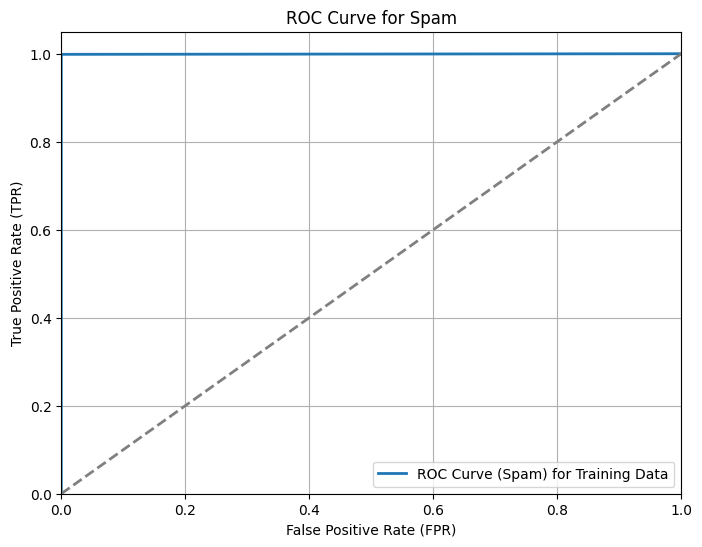

Number of emails classified as Spam, that are actually non-spam: 
0.0% emails
Number of emails classified as Spam, that are actually Spam: 
99.85950671245706% emails


In [14]:
# Set a Threshold to classify an email as Spam
threshold = 0.5
pred_prob_threshold = []

for i in range(len(pred_probs_train)):
    if pred_probs_train[i] > threshold:
        pred_prob_threshold.append(1)
    else:
        pred_prob_threshold.append(-1)

# Calculate ROC curve for class +1 (Spam)
fpr_spam, tpr_spam, _ = roc_curve(Y_train_bow, pred_prob_threshold, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr_spam, tpr_spam, lw=2, label='ROC Curve (Spam) for Training Data')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Spam')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# False Positive rate for this ROC gives the number of emails that are legitimate, but classified as spam
print("Number of emails classified as Spam, that are actually non-spam: ")
print(str(fpr_spam[1]*100) + "% emails")

print("Number of emails classified as Spam, that are actually Spam: ")
print(str(tpr_spam[1]*100) + "% emails")

In [15]:
# Evaluate on test data

# Load the dataset
test_bow = scipy.io.loadmat('datasets/top_nk_test.mat')
X_test_bow = test_bow['X']
X_test_bow = X_test_bow.toarray()
X_test_bow.shape

(2000, 10000)

In [16]:
Y_test_bow = test_bow['Y']
Y_test_bow = Y_test_bow.toarray()
Y_test_bow = Y_test_bow.ravel()
Y_test_bow.shape 

(2000,)

63/63 [==============================] - 0s 3ms/step


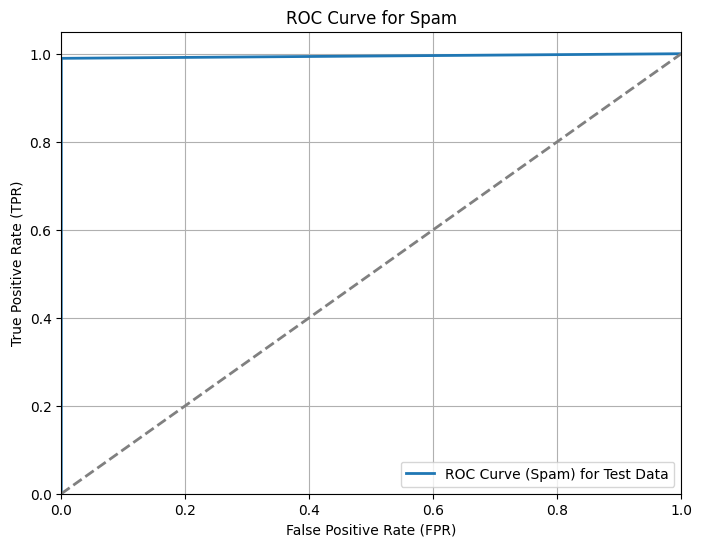

Number of emails classified as Spam, that are actually non-spam: 
0.0% emails
Number of emails classified as Spam, that are actually Spam: 
98.95320197044335% emails
AUC-ROC score: 0.9947660098522167


In [17]:
pred_probs_test = nn_clf_best.predict(X_test_bow)
threshold = 0.5 # Take threshold from Training parameters
pred_prob_threshold = []

for i in range(len(pred_probs_test)):
    if pred_probs_test[i] > threshold:
        pred_prob_threshold.append(1)
    else:
        pred_prob_threshold.append(-1)

# Calculate ROC curve for class +1 (Spam)
fpr_spam, tpr_spam, _ = roc_curve(Y_test_bow, pred_prob_threshold, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr_spam, tpr_spam, lw=2, label='ROC Curve (Spam) for Test Data')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Spam')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("Number of emails classified as Spam, that are actually non-spam: ")
print(str(fpr_spam[1]*100) + "% emails")

print("Number of emails classified as Spam, that are actually Spam: ")
print(str(tpr_spam[1]*100) + "% emails")

score = roc_auc_score(Y_test_bow, pred_prob_threshold)
print("AUC-ROC score: " + str(score))

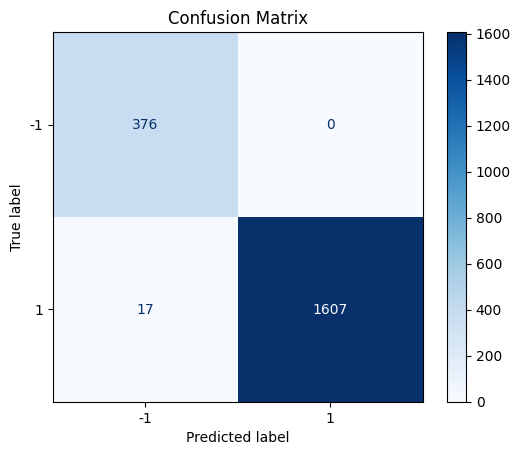

In [18]:
cm = confusion_matrix(Y_test_bow, pred_prob_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

### (2) Random Forest on TFIDF data

In [19]:
# Load the dataset for training
train_tfidf = scipy.io.loadmat('datasets/train_df.mat')
X_train_tfidf = train_tfidf['X']
X_train_tfidf = X_train_tfidf.toarray()
X_train_tfidf.shape


(8000, 5000)

In [20]:

Y_train_tfidf = train_tfidf['Y']
Y_train_tfidf = Y_train_tfidf.toarray()
Y_train_tfidf = Y_train_tfidf.ravel()
Y_train_tfidf.shape 

(8000,)

In [27]:
def create_model(hidden_layers=1, layer_length=64, activation='relu', optimizer='adam'):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_tfidf.shape[1],)))

    for _ in range(hidden_layers):
        model.add(layers.Dense(layer_length, activation=activation))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
hyperparameters = {
    'hidden_layers': [1, 2],
    'layer_length': [64, 128, 256],
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam']
}

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
# Perform the grid search manually
best_score = 0

In [ ]:
import warnings
warnings.filterwarnings("ignore")

for hidden_layers in hyperparameters['hidden_layers']:
    for layer_length in hyperparameters['layer_length']:
        for activation in hyperparameters['activation']:
            for optimizer in hyperparameters['optimizer']:
                auc_scores = []

                print("For parameters: ")
                print("Hidden layers: " + str(hidden_layers))
                print("Layer Length: " + str(layer_length))
                print("Activation function: " + str(activation))
                print("Optimizer: " + str(optimizer))

                for train_index, val_index in cv.split(X_train_tfidf, X_train_tfidf):
                    X_train, X_val = X_train_tfidf[train_index], X_train_tfidf[val_index]
                    Y_train, Y_val = Y_train_tfidf[train_index], Y_train_tfidf[val_index]

                    model = create_model(hidden_layers, layer_length, activation, optimizer)
                    model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=0)

                    Y_prob = model.predict(X_val)
                    auc = roc_auc_score(Y_val, Y_prob)
                    auc_scores.append(auc)

                mean_auc = np.mean(auc_scores)

                if mean_auc > best_score:
                    best_score = mean_auc
                    best_params = {
                        'hidden_layers': hidden_layers,
                        'layer_length': layer_length,
                        'activation': activation,
                        'optimizer': optimizer
                    }


In [110]:
best_params, best_score

({'hidden_layers': 2,
  'layer_length': 64,
  'activation': 'sigmoid',
  'optimizer': 'adam'},
 0.9997846359705219)

In [26]:
best_params = {'hidden_layers': 2,
  'layer_length': 64,
  'activation': 'sigmoid',
  'optimizer': 'adam'}

In [28]:
# Train the final model with the best hyperparameters
nn_clf_best = create_model(**best_params)
nn_clf_best.fit(X_train_tfidf, Y_train_tfidf, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
250/250 - 1s - loss: 0.2513 - accuracy: 0.6919 - 1s/epoch - 6ms/step
Epoch 2/10
250/250 - 1s - loss: -2.3238e+00 - accuracy: 0.7074 - 1000ms/epoch - 4ms/step
Epoch 3/10
250/250 - 1s - loss: -5.6186e+00 - accuracy: 0.7641 - 1s/epoch - 4ms/step
Epoch 4/10
250/250 - 1s - loss: -8.3521e+00 - accuracy: 0.7814 - 1s/epoch - 5ms/step
Epoch 5/10
250/250 - 1s - loss: -1.0775e+01 - accuracy: 0.7861 - 1s/epoch - 5ms/step
Epoch 6/10
250/250 - 1s - loss: -1.3036e+01 - accuracy: 0.7910 - 1s/epoch - 5ms/step
Epoch 7/10
250/250 - 1s - loss: -1.5211e+01 - accuracy: 0.7944 - 1s/epoch - 4ms/step
Epoch 8/10
250/250 - 1s - loss: -1.7327e+01 - accuracy: 0.7951 - 1s/epoch - 4ms/step
Epoch 9/10
250/250 - 1s - loss: -1.9423e+01 - accuracy: 0.7952 - 1s/epoch - 5ms/step
Epoch 10/10
250/250 - 1s - loss: -2.1479e+01 - accuracy: 0.7956 - 981ms/epoch - 4ms/step


In [29]:
# Evaluate on Training Data
pred_probs_train = nn_clf_best.predict(X_train_tfidf)
pred_probs_train.shape

250/250 [==============================] - 1s 2ms/step


(8000, 1)

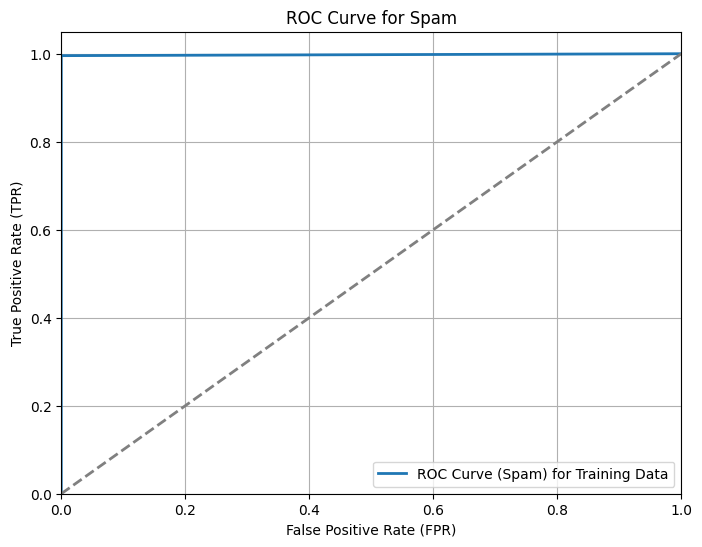

Number of emails classified as Spam, that are actually non-spam: 
0.0% emails
Number of emails classified as Spam, that are actually Spam: 
99.56290977208867% emails


In [30]:
# Set a Threshold to classify an email as Spam
threshold = 0.001
pred_prob_threshold = []

for i in range(len(pred_probs_train)):
    if pred_probs_train[i] > threshold:
        pred_prob_threshold.append(1)
    else:
        pred_prob_threshold.append(-1)

# Calculate ROC curve for class +1 (Spam)
fpr_spam, tpr_spam, _ = roc_curve(Y_train_tfidf, pred_prob_threshold, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr_spam, tpr_spam, lw=2, label='ROC Curve (Spam) for Training Data')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Spam')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# False Positive rate for this ROC gives the number of emails that are legitimate, but classified as spam
print("Number of emails classified as Spam, that are actually non-spam: ")
print(str(fpr_spam[1]*100) + "% emails")

print("Number of emails classified as Spam, that are actually Spam: ")
print(str(tpr_spam[1]*100) + "% emails")

In [31]:
# Evaluate on test data

# Load the dataset
test_tfidf = scipy.io.loadmat('datasets/test_df.mat')
X_test_tfidf = test_tfidf['X']
X_test_tfidf = X_test_tfidf.toarray()
X_test_tfidf.shape # (2000, 5000)


(2000, 5000)

In [32]:
Y_test_tfidf = test_tfidf['Y']
Y_test_tfidf = Y_test_tfidf.toarray()
Y_test_tfidf = Y_test_tfidf.ravel()
Y_test_tfidf.shape #(2000,)

(2000,)

63/63 [==============================] - 0s 2ms/step


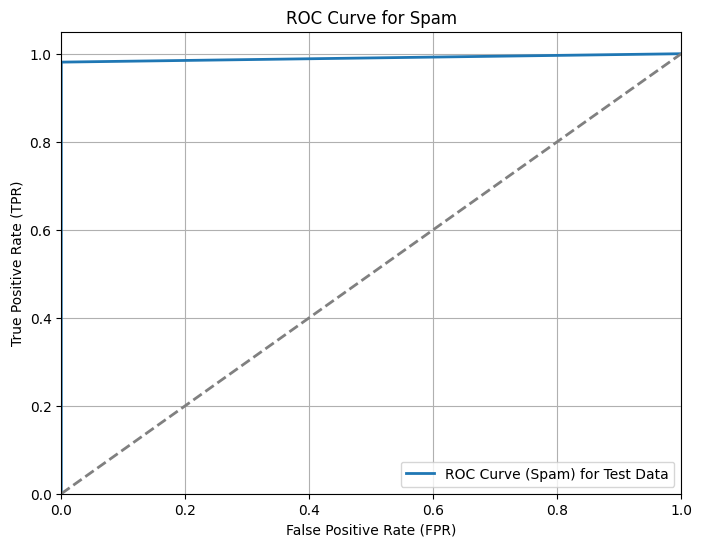

Number of emails classified as Spam, that are actually non-spam: 
0.0% emails
Number of emails classified as Spam, that are actually Spam: 
98.0911330049261% emails
AUC-ROC score: 0.9904556650246306


In [33]:
pred_probs_test = nn_clf_best.predict(X_test_tfidf)
threshold = 0.001 # Take threshold from Training parameters
pred_prob_threshold = []

for i in range(len(pred_probs_test)):
    if pred_probs_test[i] > threshold:
        pred_prob_threshold.append(1)
    else:
        pred_prob_threshold.append(-1)

# Calculate ROC curve for class +1 (Spam)
fpr_spam, tpr_spam, _ = roc_curve(Y_test_tfidf, pred_prob_threshold, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr_spam, tpr_spam, lw=2, label='ROC Curve (Spam) for Test Data')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Spam')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("Number of emails classified as Spam, that are actually non-spam: ")
print(str(fpr_spam[1]*100) + "% emails")

print("Number of emails classified as Spam, that are actually Spam: ")
print(str(tpr_spam[1]*100) + "% emails")

score = roc_auc_score(Y_test_tfidf, pred_prob_threshold)
print("AUC-ROC score: " + str(score))

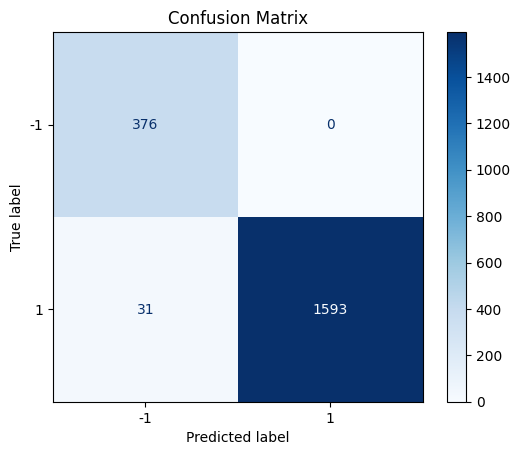

In [34]:
cm = confusion_matrix(Y_test_tfidf, pred_prob_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()